## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

Do this in order to install Reddit Python library:
`pip install praw`.

Library docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html



### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

In [2]:
#!pip install praw

Now we need to setup Reddit data fetching. For this we need to have a Reddit account.

We'll use posts from https://www.reddit.com/r/Paranormal/comments/gc4ive/i_made_another_big_list_of_paranormal_and_mystery/ for inspiration.

Now, create `client_id` and `client_secret`.

How?
  - Create a Reddit account if you don't have one yet
  - Go to https://www.reddit.com/prefs/apps and click `create an app`
  - Pick `script` app type. Name and description can be anything, but make sure to specify `http://localhost:8080` as `redirect uri`
  - Press `create app`. Your `client_id` is the string under **personal use script** and `client_secret` is the string next to **secret**

In [1]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = 'SerFLqkABV-wAiaTAITYaA',
    client_secret = 'oquE-EcmSOvGZ688NPzgLYDrcdO_jg',
    user_agent = 'praw'
)

# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    for i in range(len(commentsList)-1):
        try:
            pandas_list.append([i, commentsList[i].body])
        except:
            try:
                pandas_list.append([i, commentsList[i].comments()[0].body])
            except:
                pass
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

In [2]:
# test getComments()
df = getComments('1n9pg5')

Install libraries & load data

In [3]:
# Install spacy quietly
!pip install spacy -q

In [16]:
# Download english language model
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [11]:
# Install wordcloud
!pip install wordcloud

1. Import pandas, numpy, spacy, sklearn (TfidfVectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud.

   `en_core_web_sm` is a trained English pipeline.

In [4]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Read reddit comments and put it in a DataFrame named `corpus`.

In [5]:
corpus = getComments('1445rgz')#pd.read_csv('./sample_data.csv')

In [6]:
print(corpus.shape)
corpus.head()

(684, 2)


,id,description
0,0,Randoming hero give you extra gold
1,1,Invoker had to wait for level 6 to get a spell.
2,2,"My hero has an orb effect, I can’t buy desolat..."
3,3,Range creep just broke my clarity.
4,4,Let me share my ring of health with you


In [7]:
print('Description of the first product : ',corpus.loc[0,'description'])

Description of the first product :  Randoming hero give you extra gold


### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Use `str` methods to clean the texts. Save cleaned-up text into a column named `clean_description`.

In [8]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  Randoming hero give you extra gold


C:\Users\oskac\AppData\Local\Temp\ipykernel_18272\3293871571.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ")
C:\Users\oskac\AppData\Local\Temp\ipykernel_18272\3293871571.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ")


4. Tranform every character into lowercase.

In [9]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  randoming hero give you extra gold


5. Use spacy to tokenize the documents and put the result in a new column named `clean_tokens`.

In [10]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,0,Randoming hero give you extra gold,randoming hero give you extra gold,"(randoming, hero, give, you, extra, gold)"
1,1,Invoker had to wait for level 6 to get a spell.,invoker had to wait for level to get a spell,"(invoker, had, to, wait, for, level, to, get, ..."
2,2,"My hero has an orb effect, I can’t buy desolat...",my hero has an orb effect i can t buy desolate...,"(my, hero, has, an, orb, effect, i, can, t, bu..."
3,3,Range creep just broke my clarity.,range creep just broke my clarity,"(range, creep, just, broke, my, clarity)"
4,4,Let me share my ring of health with you,let me share my ring of health with you,"(let, me, share, my, ring, of, health, with, you)"


6. Remove the stop words and lemmatize `clean_tokens`

In [11]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,0,Randoming hero give you extra gold,randoming hero give you extra gold,"[randome, hero, extra, gold]"
1,1,Invoker had to wait for level 6 to get a spell.,invoker had to wait for level to get a spell,"[invoker, wait, level, spell]"
2,2,"My hero has an orb effect, I can’t buy desolat...",my hero has an orb effect i can t buy desolate...,"[hero, orb, effect, t, buy, desolate, skadi, g..."
3,3,Range creep just broke my clarity.,range creep just broke my clarity,"[range, creep, break, clarity]"
4,4,Let me share my ring of health with you,let me share my ring of health with you,"[let, share, ring, health]"


7. Write all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [12]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,0,Randoming hero give you extra gold,randoming hero give you extra gold,"[randome, hero, extra, gold]",randome hero extra gold
1,1,Invoker had to wait for level 6 to get a spell.,invoker had to wait for level to get a spell,"[invoker, wait, level, spell]",invoker wait level spell
2,2,"My hero has an orb effect, I can’t buy desolat...",my hero has an orb effect i can t buy desolate...,"[hero, orb, effect, t, buy, desolate, skadi, g...",hero orb effect t buy desolate skadi game
3,3,Range creep just broke my clarity.,range creep just broke my clarity,"[range, creep, break, clarity]",range creep break clarity
4,4,Let me share my ring of health with you,let me share my ring of health with you,"[let, share, ring, health]",let share ring health


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. Perform TF-IDF transformation using the data from the column `clean_document`.

In [13]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(684, 1603)


In [14]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('aa', 0), ('aah', 1), ('abaddon', 2), ('abilite', 3), ('ability', 4), ('able', 5), ('absurd', 6), ('abysal', 7), ('accept', 8), ('accidentally', 9), ('active', 10), ('actual', 11), ('actually', 12), ('add', 13), ('additional', 14), ('address', 15), ('adjg', 16), ('advanced', 17), ('adventure', 18), ('advocate', 19), ('aegie', 20), ('aegis', 21), ('af', 22), ('afaik', 23), ('afford', 24), ('afraid', 25), ('aggro', 26), ('aghanim', 27), ('aghs', 28), ('agi', 29), ('ago', 30), ('agree', 31), ('ah', 32), ('ahahahaahha', 33), ('aka', 34), ('akasha', 35), ('alchemist', 36), ('alert', 37), ('alliance', 38), ('allow', 39), ('alt', 40), ('alter', 41), ('amp', 42), ('ancestor', 43), ('ancient', 44), ('animation', 45), ('annoyance', 46), ('annoying', 47), ('annyoe', 48), ('ans', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [15]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names_out(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,aa,aah,abaddon,abilite,ability,able,absurd,abysal,accept,accidentally,...,yooo,youtu,youtube,yup,yurnero,zacjev,zeal,zeus,zhou,zone
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Each line of X correspond to a product description.
- Each column of X correspond to a word into the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word in a product description.

3. Use DBSCAN to make some clustering on the TF-IDF matrix.

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.

When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

- When dealing with texts, the distance metric to be used is cosine instead of euclidean 
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

In [16]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,Randoming hero give you extra gold,randoming hero give you extra gold,"[randome, hero, extra, gold]",randome hero extra gold,0
1,1,Invoker had to wait for level 6 to get a spell.,invoker had to wait for level to get a spell,"[invoker, wait, level, spell]",invoker wait level spell,0
2,2,"My hero has an orb effect, I can’t buy desolat...",my hero has an orb effect i can t buy desolate...,"[hero, orb, effect, t, buy, desolate, skadi, g...",hero orb effect t buy desolate skadi game,0
3,3,Range creep just broke my clarity.,range creep just broke my clarity,"[range, creep, break, clarity]",range creep break clarity,1
4,4,Let me share my ring of health with you,let me share my ring of health with you,"[let, share, ring, health]",let share ring health,0


,aa,aah,abaddon,abilite,ability,able,absurd,abysal,accept,accidentally,...,youtu,youtube,yup,yurnero,zacjev,zeal,zeus,zhou,zone,cluster_id
item_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
item_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
item_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
item_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
item_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


4. Display number of documents in each cluster

In [17]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

 0     335
-1     273
 12     10
 3       8
 9       7
 1       7
 6       6
 8       6
 4       4
 10      4
 2       3
 16      3
 11      3
 7       3
 14      3
 15      3
 13      3
 5       3
Name: cluster_id, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [18]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  0  :
----
i remember top comment on courier change was we turbo now boys 

i remember garena warkeys teamspeak

dota apem us ca pros only

-----------
CLUSTER  -1  :
----
my mate still advocates for this and it winds me up to no end removing one item from heroes does not address the problem 

the good ol days he was so friggin broken back then but it was fun 

my friend who taught me to play dota basically always recommended i buy tangoes over salve because they couldn t be canceled by taking damage what a weird time 

-----------
CLUSTER  12  :
----
not since haha patch 

remember that one patch when if made the cooldown s 

nope

-----------
CLUSTER  3  :
----
guinsoo

guinsoo

lothar s edge

-----------
CLUSTER  9  :
----
riki with deathward ulti silencer with meteor golem

diffusal instantly kill warlock golem

inferno being warlock ulti with golem drops

-----------


6. Print the 5 most frequent words in the 5 first clusters

In [19]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  0
buy        0.049067
courier    0.035705
dota       0.021817
time       0.019232
orb        0.019041
dtype: float64
-----------
CLUSTER  -1
play        0.023296
game        0.018547
remember    0.016320
like        0.015457
hero        0.014983
dtype: float64
-----------
CLUSTER  12
patch       0.281138
nope        0.166570
cooldown    0.154105
greave      0.142878
mana        0.118286
dtype: float64
-----------
CLUSTER  3
guinsoo    0.362003
lothar     0.347123
edge       0.095746
op         0.088864
scythe     0.076010
dtype: float64
-----------
CLUSTER  9
golem       0.260404
diffusal    0.258237
warlock     0.212163
purge       0.133389
silencer    0.126437
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  0


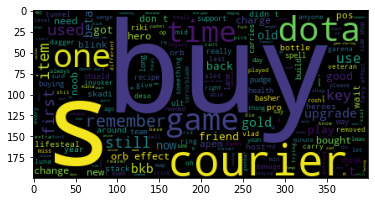

-----------
CLUSTER  -1


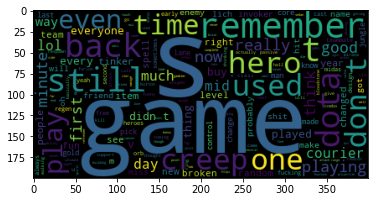

-----------
CLUSTER  12


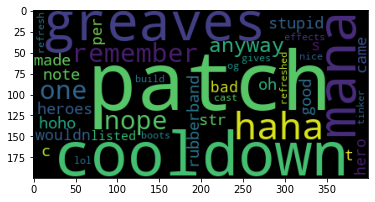

-----------
CLUSTER  3


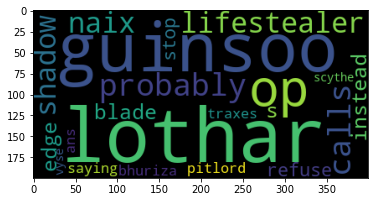

-----------
CLUSTER  9


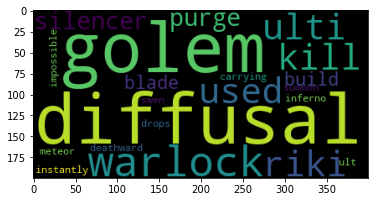

-----------


In [20]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - Recommender system <a class="anchor" id="chapter3"></a>

Now, we use the clusters created from part 1 to build a recommender system. 
The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we consider that products belonging to the same cluster are similar.

In [21]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,0,Randoming hero give you extra gold,randoming hero give you extra gold,"[randome, hero, extra, gold]",randome hero extra gold,0
1,1,Invoker had to wait for level 6 to get a spell.,invoker had to wait for level to get a spell,"[invoker, wait, level, spell]",invoker wait level spell,0
2,2,"My hero has an orb effect, I can’t buy desolat...",my hero has an orb effect i can t buy desolate...,"[hero, orb, effect, t, buy, desolate, skadi, g...",hero orb effect t buy desolate skadi game,0
3,3,Range creep just broke my clarity.,range creep just broke my clarity,"[range, creep, break, clarity]",range creep break clarity,1
4,4,Let me share my ring of health with you,let me share my ring of health with you,"[let, share, ring, health]",let share ring health,0


1. Create a function named `find_similar_items` that will return the 5 item ids belonging to the same cluster as the product `item_id`.

In [22]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

2. Use `input()` function to allow the user to choose a product and submit some suggestions of similar items.

In [23]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [27]:
product_id = int(input("What product would you like to buy ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print(f"{bcolors.OKBLUE}Product found in database, description below :")
    print(item_desc)
    print()
    
    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')

What product would you like to buy ? 5

Product found in database, description below :
spamming the deliver item button and see who wins the battle of wit

Based on the analysis of the products' descriptions, you might also be interested by the following products : 

Item # 555
i actually liked only having one courier the game seemed a little slower then now everyone can just ferry out regen don t get me wrong i like everyone having their own courier but it really changed the early game 
--------------------
Item # 496
earth and ember will always be new to me because i played hon while they were introduced in dota they are far more advanced heroes than earlier designs imo the spirits are up there for the frogs magnum opus 
--------------------
Item # 33
i member when storm was clunky chubby one pack old dude
--------------------
Item # 450
 oos
--------------------
Item # 107
can t think of anything for dota but in dota there was no ranked matchmaking courier costed g and you could den

## Part 4 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example Sport and Politics.

1. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [28]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.106556,-0.116418,0.001879,-0.031924,-0.054209,-0.042533,-0.129652,-0.173586,0.032939,-0.188388,-0.211073,-0.074499,randoming hero give you extra gold
1,0.059587,-0.113671,-0.002991,-0.051527,-0.025670,-0.018893,0.061143,0.000915,0.008160,0.026994,-0.121886,-0.031422,invoker had to wait for level to get a spell
2,0.336443,-0.250979,-0.000019,0.469041,0.075691,0.047975,-0.089020,-0.150434,0.060525,-0.026992,0.018577,-0.022021,my hero has an orb effect i can t buy desolate...
3,0.039832,-0.067042,0.007950,-0.009253,-0.004954,-0.049177,-0.042602,0.070583,-0.048199,0.016554,-0.032147,0.207670,range creep just broke my clarity
4,0.069958,0.004261,-0.004238,-0.041995,-0.001359,-0.009401,-0.046074,-0.077438,-0.007141,-0.010906,-0.124680,0.022595,let me share my ring of health with you


Contrary to clustering, LSA allows to map each document to a mix of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Create a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document.

In [29]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.106556,-0.116418,0.001879,-0.031924,-0.054209,-0.042533,-0.129652,-0.173586,0.032939,-0.188388,-0.211073,-0.074499,randoming hero give you extra gold,topic_10
1,0.059587,-0.113671,-0.002991,-0.051527,-0.025670,-0.018893,0.061143,0.000915,0.008160,0.026994,-0.121886,-0.031422,invoker had to wait for level to get a spell,topic_10
2,0.336443,-0.250979,-0.000019,0.469041,0.075691,0.047975,-0.089020,-0.150434,0.060525,-0.026992,0.018577,-0.022021,my hero has an orb effect i can t buy desolate...,topic_3
3,0.039832,-0.067042,0.007950,-0.009253,-0.004954,-0.049177,-0.042602,0.070583,-0.048199,0.016554,-0.032147,0.207670,range creep just broke my clarity,topic_11
4,0.069958,0.004261,-0.004238,-0.041995,-0.001359,-0.009401,-0.046074,-0.077438,-0.007141,-0.010906,-0.124680,0.022595,let me share my ring of health with you,topic_10


3. Count each main topic in the corpus 

In [30]:
topic_encoded_df['main_topic'].value_counts()

topic_10    115
topic_11    108
topic_0     102
topic_1      70
topic_7      59
topic_8      58
topic_6      46
topic_9      36
topic_3      34
topic_4      28
topic_5      22
topic_2       6
Name: main_topic, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Use the attribute `components_` of the SVD model to print the 5 most important words in each topic.

In [31]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,aa,aah,abaddon,abilite,ability,able,absurd,abysal,accept,accidentally,...,yooo,youtu,youtube,yup,yurnero,zacjev,zeal,zeus,zhou,zone
topic_0,0.007506,0.001183,0.008860,0.001934,0.023948,0.034208,0.000257,0.000843,0.011662,0.001039,...,0.000429,0.001234,0.000631,0.001465,0.001617,4.604486e-07,0.001180,0.001627,3.463685e-07,0.005077
topic_1,0.018407,0.001834,0.005662,0.003474,0.004273,0.025334,0.000582,0.000887,0.002362,0.000995,...,0.001396,0.003578,0.001586,0.002966,0.003336,6.066702e-06,0.001425,0.003860,5.030444e-06,0.011866
topic_2,0.001482,0.000049,0.000183,0.000202,0.000689,0.002108,0.000051,0.000069,0.000816,0.000020,...,0.000148,0.000845,0.000509,0.000209,0.000071,1.242069e-06,0.000333,0.000216,1.793311e-05,0.000377
topic_3,0.010004,0.002003,0.007867,0.005118,0.014531,0.006563,0.000414,0.000925,0.007824,0.001001,...,0.001142,0.000901,0.000277,0.002958,0.002054,4.230380e-07,0.000477,0.003071,1.600126e-05,0.008850
topic_4,0.004201,0.000809,0.003628,0.002738,0.009777,0.034908,0.000451,0.002104,0.008449,0.000746,...,0.000596,0.000366,0.000605,0.002600,0.000612,8.875299e-06,0.000359,0.002806,2.649128e-05,0.004948


In [32]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['buy', 'courier', 'game', 'upgrade', 'remember']

-------------------------

TOPIC : topic_1
['courier', 'buy', 'play', 'orb', 'dota']

-------------------------

TOPIC : topic_2
['delete', 'game', 'new', 'shop', 'tunnel']

-------------------------

TOPIC : topic_3
['orb', 'effect', 'buy', 'stack', 'play']

-------------------------

TOPIC : topic_4
['courier', 'buy', 'upgrade', 'orb', 'effect']

-------------------------

TOPIC : topic_5
['apem', 'noob', 'host', 'pro', 'tunnel']

-------------------------

TOPIC : topic_6
['dota', 'game', 'key', 'host', 'noob']

-------------------------

TOPIC : topic_7
['time', 'game', 'dota', 'remember', 'blink']

-------------------------

TOPIC : topic_8
['riki', 'ward', 'death', 'apem', 'time']

-------------------------

TOPIC : topic_9
['apem', 'key', 'host', 'tunnel', 'time']

-------------------------

TOPIC : topic_10
['game', 'hero', 'like', 'miss', 'time']

-------------------------

TOPIC : topic_11
['remember', 'pudge'

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [33]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.106556,-0.116418,0.001879,-0.031924,-0.054209,-0.042533,-0.129652,-0.173586,0.032939,-0.188388,-0.211073,-0.074499,randoming hero give you extra gold,topic_10
1,0.059587,-0.113671,-0.002991,-0.051527,-0.025670,-0.018893,0.061143,0.000915,0.008160,0.026994,-0.121886,-0.031422,invoker had to wait for level to get a spell,topic_10
2,0.336443,-0.250979,-0.000019,0.469041,0.075691,0.047975,-0.089020,-0.150434,0.060525,-0.026992,0.018577,-0.022021,my hero has an orb effect i can t buy desolate...,topic_3
3,0.039832,-0.067042,0.007950,-0.009253,-0.004954,-0.049177,-0.042602,0.070583,-0.048199,0.016554,-0.032147,0.207670,range creep just broke my clarity,topic_11
4,0.069958,0.004261,-0.004238,-0.041995,-0.001359,-0.009401,-0.046074,-0.077438,-0.007141,-0.010906,-0.124680,0.022595,let me share my ring of health with you,topic_10


-------------------------

TOPIC  topic_0


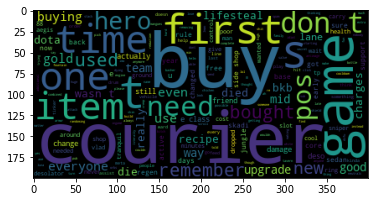


-------------------------

TOPIC  topic_1


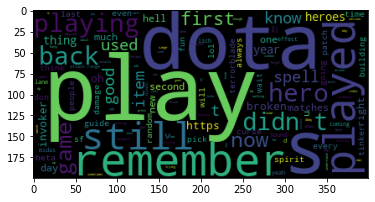


-------------------------

TOPIC  topic_2


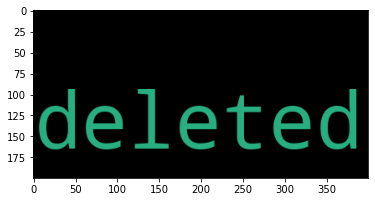


-------------------------

TOPIC  topic_3


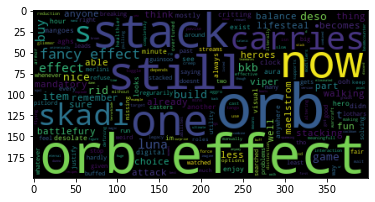


-------------------------

TOPIC  topic_4


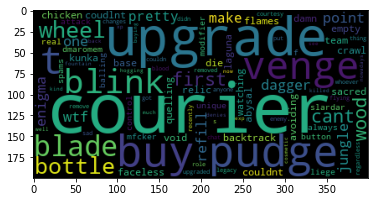


-------------------------

TOPIC  topic_5


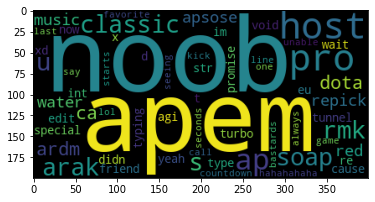


-------------------------

TOPIC  topic_6


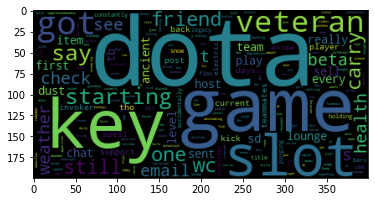


-------------------------

TOPIC  topic_7


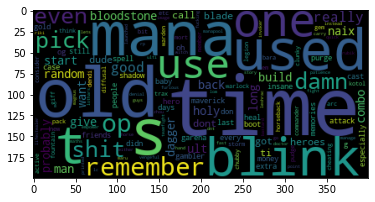


-------------------------

TOPIC  topic_8


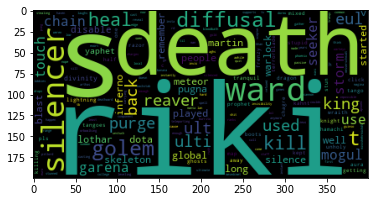


-------------------------

TOPIC  topic_9


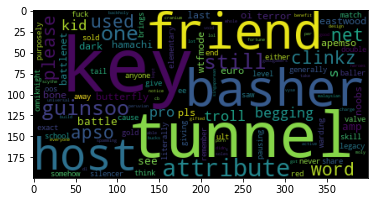


-------------------------

TOPIC  topic_10


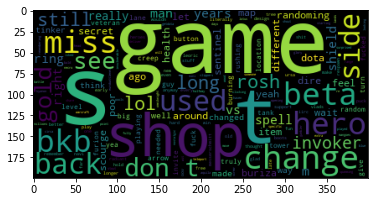


-------------------------

TOPIC  topic_11


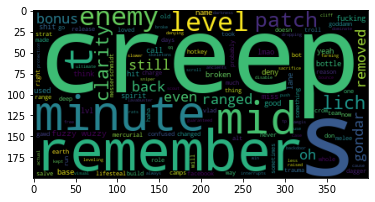

In [34]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.